In [1]:
import datetime as dt
import time

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import warnings

from GoogleEarth import GoogleEarth
from Simulator import Simulator

warnings.filterwarnings("ignore")

In [2]:
# Data
df_gases = pd.DataFrame(index=["VC", "BE", "2-EHA", "IB", "BA", "BZ"])
df_gases["Capacity"] = [490000, 114000, 98000, 114000, 114000, 228000]  # The compressed volume in L
df_gases["Mass"] = [402500, 84255, 93400, 70600, 81650, 177000]  # The mass in kg
df_shp = gpd.read_file("../data/geoshape/cb_2018_us_cbsa_20m/cb_2018_us_cbsa_20m.shp")

In [3]:
source = -80.52, 40.84
start_time = dt.datetime(2023, 2, 3, 21)
end_time = dt.datetime(2023, 2, 6, 0)
iteration_interval = dt.timedelta(hours=1)
simulator_interval = dt.timedelta(seconds=1200)
ge = GoogleEarth()
simulator = Simulator(start_time, end_time, source, iteration_interval, simulator_interval, ge, 1)

It takes 0.676 to simulate 20230203 220000 status of size 3
It takes 0.558 to simulate 20230203 230000 status of size 11
It takes 1.205 to simulate 20230204 000000 status of size 32
It takes 0.601 to simulate 20230204 010000 status of size 64
It takes 1.723 to simulate 20230204 020000 status of size 105
It takes 0.716 to simulate 20230204 030000 status of size 154
It takes 0.852 to simulate 20230204 040000 status of size 232
It takes 1.014 to simulate 20230204 050000 status of size 368
It takes 1.171 to simulate 20230204 060000 status of size 549
It takes 1.499 to simulate 20230204 070000 status of size 634
It takes 1.487 to simulate 20230204 080000 status of size 698
It takes 1.616 to simulate 20230204 090000 status of size 822
It takes 2.011 to simulate 20230204 100000 status of size 957
It takes 1.853 to simulate 20230204 110000 status of size 1029
It takes 1.894 to simulate 20230204 120000 status of size 1134
It takes 4.422 to simulate 20230204 130000 status of size 1258
It takes 4

KeyboardInterrupt: 

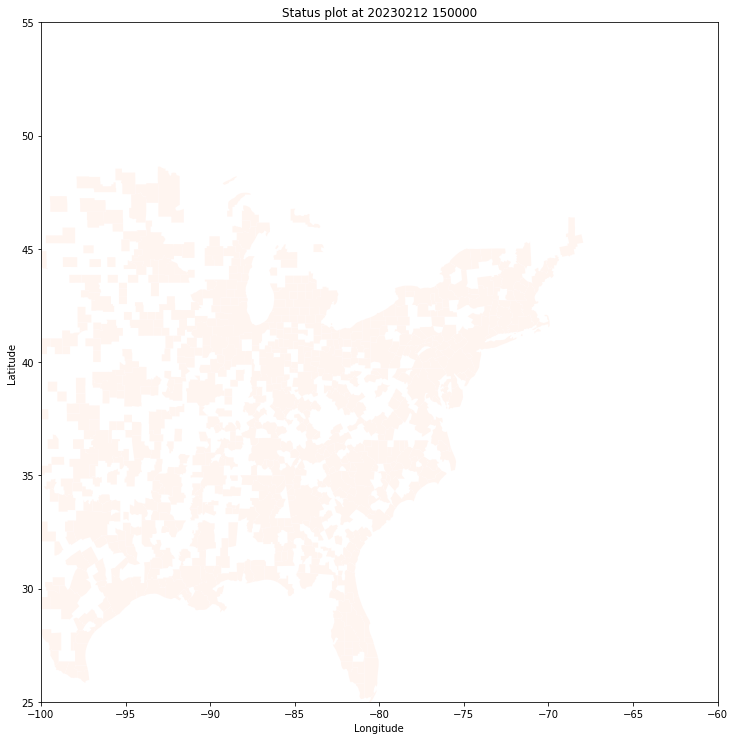

In [4]:
simulator = Simulator(start_time, end_time, source, iteration_interval, simulator_interval, ge, 1)
for _ in range(24 * 20):
    t = time.time()
    simulator.step()
    
    status_time = simulator.time
    status = simulator.get_status()
    df_status = simulator.plot_status(status, df_shp, status_time)
    status_time = status_time.strftime("%Y%m%d %H%M%S")
    plt.savefig(f"../simulation/{status_time}.png")
    status.to_csv(f"../simulation/{status_time}.csv")
    plt.close()
    print(f"It takes {round(time.time() - t, 3)} to simulate {status_time} status of size {len(simulator.status)}")
    